In [44]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FuncFormatter


def process_clonotypes_with_umi(folder_path, output_file, umi_threshold=10):
    """
    Process clonotype data from multiple TSV files in a folder, 
    filter by uniqueMoleculeCount, and save the results to an output CSV file.

    Parameters:
    - folder_path: Path to the folder containing TSV files.
    - output_file: Path to the output CSV file.
    - umi_threshold: The minimum value of 'uniqueMoleculeCount' to filter clonotypes (default is 10).
    """
    # List to hold all clonotype data with filename, count, and TotalUMI
    all_clonotype_data = []

    # Traverse through all files in the folder and subfolders
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".tsv"):  # Process only .tsv files
                file_path = os.path.join(root, filename)
                print(f"Processing file: {file_path}")

                # Load the TSV file
                data = pd.read_csv(file_path, sep='\t')

                # Check if required columns exist
                if 'aaSeqCDR3' in data.columns and 'uniqueMoleculeCount' in data.columns:
                    # Drop rows with missing values in the required columns
                    filtered_data = data[['aaSeqCDR3', 'uniqueMoleculeCount']].dropna()

                    # Filter by uniqueMoleculeCount threshold
                    filtered_data = filtered_data[filtered_data['uniqueMoleculeCount'] >= umi_threshold]

                    # Group by Clonotype (aaSeqCDR3) and calculate Count and TotalUMI
                    grouped = filtered_data.groupby('aaSeqCDR3').agg(
                        Count=('aaSeqCDR3', 'size'),
                        TotalUMI=('uniqueMoleculeCount', 'sum')
                    ).reset_index()

                    # Add the filename column
                    grouped['Filename'] = filename

                    # Append to the overall data list
                    all_clonotype_data.append(grouped)
                else:
                    print(f"Warning: Required columns ('aaSeqCDR3', 'uniqueMoleculeCount') not found in {filename}")

    # Concatenate all results into a single DataFrame
    if all_clonotype_data:
        result_df = pd.concat(all_clonotype_data, ignore_index=True)
        result_df.rename(columns={'aaSeqCDR3': 'Clonotype'}, inplace=True)

        # Reorder columns for clarity
        result_df = result_df[['Filename', 'Clonotype', 'Count', 'TotalUMI']]

        # Save the result to a CSV file
        result_df.to_csv(output_file, index=False)
        print(f"Clonotype data saved to {output_file}")

    return result_df if all_clonotype_data else None

In [45]:
# import pandas as pd
# import os
# from matplotlib_venn import venn4
# import matplotlib.pyplot as plt

# def process_and_plot_venn(input_csv, output_venn_plot="venn_diagram.png"):
#     """
#     Process clonotype data from a CSV file, add a SimplifiedName column based on Filename,
#     then create and save a Venn diagram showing clonotype overlaps between files,
#     using SimplifiedName for the plot labels, for up to four files.

#     Parameters:
#     - input_csv: Path to the input CSV file containing clonotype data.
#     - output_venn_plot: Path to save the Venn diagram plot image.
#     """
#     # Load the data from the CSV file
#     data = pd.read_csv(input_csv)

#     # Add the SimplifiedName column by applying the lambda function to 'Filename'
#     data['SimplifiedName'] = data['Filename'].apply(lambda x: "_".join(x.split("_")[2:5]))

#     # Extract clonotypes for each filename (grouping by 'Filename')
#     files = data['Filename'].unique()  # Get unique filenames (experiments)

#     # Ensure we have at least four files for the Venn diagram
#     if len(files) < 4:
#         print("Error: At least four files are required to create a Venn diagram.")
#         return

#     # Create sets of clonotypes for each file
#     clonotypes_per_file = {}
#     for file in files:
#         clonotypes_per_file[file] = set(data[data['Filename'] == file]['Clonotype'])

#     # Example: Comparing the first four files
#     clonotypes_file_1 = clonotypes_per_file[files[0]]
#     clonotypes_file_2 = clonotypes_per_file[files[1]]
#     clonotypes_file_3 = clonotypes_per_file[files[2]]
#     clonotypes_file_4 = clonotypes_per_file[files[3]]

#     # Find overlaps between the clonotype sets
#     only_file_1 = clonotypes_file_1 - clonotypes_file_2 - clonotypes_file_3 - clonotypes_file_4
#     only_file_2 = clonotypes_file_2 - clonotypes_file_1 - clonotypes_file_3 - clonotypes_file_4
#     only_file_3 = clonotypes_file_3 - clonotypes_file_1 - clonotypes_file_2 - clonotypes_file_4
#     only_file_4 = clonotypes_file_4 - clonotypes_file_1 - clonotypes_file_2 - clonotypes_file_3
#     file_1_and_2 = clonotypes_file_1 & clonotypes_file_2
#     file_1_and_3 = clonotypes_file_1 & clonotypes_file_3
#     file_1_and_4 = clonotypes_file_1 & clonotypes_file_4
#     file_2_and_3 = clonotypes_file_2 & clonotypes_file_3
#     file_2_and_4 = clonotypes_file_2 & clonotypes_file_4
#     file_3_and_4 = clonotypes_file_3 & clonotypes_file_4
#     all_files = clonotypes_file_1 & clonotypes_file_2 & clonotypes_file_3 & clonotypes_file_4

#     # Prepare data for the Venn diagram
#     venn_data = {
#         '1000': len(only_file_1),   # Only in file 1
#         '0100': len(only_file_2),   # Only in file 2
#         '0010': len(only_file_3),   # Only in file 3
#         '0001': len(only_file_4),   # Only in file 4
#         '1100': len(file_1_and_2),  # Shared between file 1 and file 2
#         '1010': len(file_1_and_3),  # Shared between file 1 and file 3
#         '1001': len(file_1_and_4),  # Shared between file 1 and file 4
#         '0110': len(file_2_and_3),  # Shared between file 2 and file 3
#         '0101': len(file_2_and_4),  # Shared between file 2 and file 4
#         '0011': len(file_3_and_4),  # Shared between file 3 and file 4
#         '1110': len(all_files),     # Shared between all 4 files
#     }

#     # Create a list of SimplifiedNames to use as labels in the Venn diagram
#     simplified_names = [data[data['Filename'] == files[0]]['SimplifiedName'].iloc[0], 
#                         data[data['Filename'] == files[1]]['SimplifiedName'].iloc[0], 
#                         data[data['Filename'] == files[2]]['SimplifiedName'].iloc[0], 
#                         data[data['Filename'] == files[3]]['SimplifiedName'].iloc[0]]

#     # Plot the Venn diagram with SimplifiedNames as labels
#     plt.figure(figsize=(8, 6))
#     venn4(subsets=venn_data, set_labels=simplified_names)
#     plt.title("Venn Diagram of Clonotype Overlap Across Files")
    
#     # Save the Venn diagram plot
#     plt.savefig(output_venn_plot)
#     plt.show()

#     print(f"Venn diagram saved as {output_venn_plot}")



ImportError: cannot import name 'venn4' from 'matplotlib_venn' (/home/rittika/.local/lib/python3.10/site-packages/matplotlib_venn/__init__.py)

In [53]:
import os
import pandas as pd
import venn
import matplotlib.pyplot as plt

def process_and_plot_venn(input_csv, output_venn_plot="venn_diagram.png", output_overlap_file="overlapping_clonotypes.csv"):
    """
    Process clonotype data from a CSV file, add a SimplifiedName column based on Filename,
    then create and save a Venn diagram showing clonotype overlaps between four files,
    using SimplifiedName for the plot labels. Also outputs the details of overlapping clonotypes.

    Parameters:
    - input_csv: Path to the input CSV file containing clonotype data.
    - output_venn_plot: Path to save the Venn diagram plot image.
    - output_overlap_file: Path to save the overlapping clonotypes details.
    """
    # Load the data from the CSV file
    data = pd.read_csv(input_csv)

    # Add the SimplifiedName column by applying the lambda function to 'Filename'
    data['SimplifiedName'] = data['Filename'].apply(lambda x: "_".join(x.split("_")[2:5]))

    # Extract clonotypes for each filename (grouping by 'Filename')
    files = data['Filename'].unique()  # Get unique filenames (experiments)

    # Ensure we have at least four files for the Venn diagram
    if len(files) < 4:
        print("Error: At least four files are required to create a Venn diagram.")
        return

    # Create sets of clonotypes for each file
    clonotypes_per_file = {}
    for file in files:
        clonotypes_per_file[file] = set(data[data['Filename'] == file]['Clonotype'])

    # Prepare the data for the Venn diagram
    venn_data = {
        files[0]: clonotypes_per_file[files[0]],
        files[1]: clonotypes_per_file[files[1]],
        files[2]: clonotypes_per_file[files[2]],
        files[3]: clonotypes_per_file[files[3]],
    }

    # Ensure the output directory exists
    folder_path = os.path.dirname(output_venn_plot)  # Get the folder path from the output file path
    if folder_path and not os.path.exists(folder_path):
        os.makedirs(folder_path)  # Create the folder if it does not exist

    # Plot the Venn diagram
    plt.figure(figsize=(8, 6))
    venn.venn(venn_data)

    # Set the title for the Venn diagram
    plt.title("Venn Diagram of Clonotype Overlap Across Assays")

    # Save the plot and show it
    plt.savefig(output_venn_plot)
    plt.show()

    print(f"Venn diagram saved as {output_venn_plot}")

    # ** New Code: Output overlapping clonotype details (overlapping all 4 samples) **

    # Get the overlapping clonotypes that are present in all 4 files
    overlapping_clonotypes = set.intersection(*clonotypes_per_file.values())

    # Extract details for the overlapping clonotypes
    overlapping_details = []

    for clonotype in overlapping_clonotypes:
        clonotype_data = data[data['Clonotype'] == clonotype]

        # For each clonotype, we want to keep the 'Clonotype', 'SimplifiedName', 'Filename', and 'UniqueMoleculeCount'
        for _, row in clonotype_data.iterrows():
            overlapping_details.append({
                'Clonotype': row['Clonotype'],
                'Filename': row['Filename'],
                'UniqueMoleculeCount': row['TotalUMI']
            })

    # Convert the overlapping details to a DataFrame and save to CSV
    overlapping_df = pd.DataFrame(overlapping_details)
    overlapping_df.to_csv(output_overlap_file, index=False)

    print(f"Overlapping clonotype details saved as {output_overlap_file}")


Processing file: /home/rittika/Workprojects/Longreads-PacBio/overlap-MME/MiXCR_IMGT_Exp4_RNA_MME_IRP_L1_PacBio.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/overlap-MME/MiXCR_IMGT_Exp2_RNA_MME_NEB_L2_PacBio.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/overlap-MME/MiXCR_IMGT_MME_HC_TKB_PacBio.clones_IGH.tsv
Processing file: /home/rittika/Workprojects/Longreads-PacBio/overlap-MME/MiXCR_IMGT_RNA_MME_B2-25ng_ABhelix_PacBio.clones_IGH.tsv
Clonotype data saved to overlap-MME_clonotypes_with_filenames_and_umi_MMe_threshold2.csv


<Figure size 800x600 with 0 Axes>

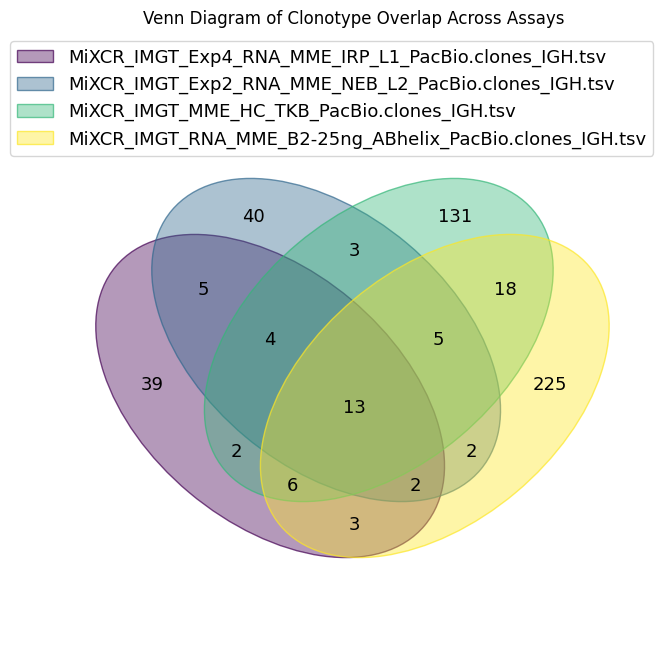

Venn diagram saved as /home/rittika/Workprojects/Longreads-PacBio/overlap-MME/clonotype_overlap_venn_MME_threshold2.png
Overlapping clonotype details saved as overlap-MME_overlapping_clonotypes_MME_threshold2.csv


In [68]:
# Define folder path
folder_path = "/home/rittika/Workprojects/Longreads-PacBio/overlap-MME"  # Replace with your folder path

# Generate dynamic output file names based on folder path
folder_name = os.path.basename(folder_path.rstrip("/\\"))
output_file = f"{folder_name}_clonotypes_with_filenames_and_umi_MMe_threshold2.csv"
output_venn_plot = os.path.join(folder_path, "clonotype_overlap_venn_MME_threshold2.png")

# Call the function
result_df = process_clonotypes_with_umi(folder_path, output_file, umi_threshold=2)
output_overlap_file = f"{folder_name}_overlapping_clonotypes_MME_threshold2.csv"
process_and_plot_venn(output_file, output_venn_plot, output_overlap_file)